In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# AES2: What are the essays about?

We know that **12871** over 17307 are from Persuade 2.0 (total=25992). We've 100% text match for these 12871 essays. For some other essays (minor) we've similarity match not taken into account here.

Hereafter a quick EDA with topics modeling to learn what are the essays about for the ones from Kaggle, Persuade and both overlapping.


| Dataset      | Dataset             | Dataset               |
| -----------  | ------------------- | --------------------- |
|  Kaggle-only (4436) | Kaggle + Persuade (12871)   | Persuade-only (13125)         |

Note: _Persuade comes with prompt_name and assignment details that gives information about the topic._

Kaggle training dataset is about:
- Solar planets exploration (Venus conditions, orgin of Mars).
- Driverless cars safety cost and legal issues.
- Voting/Election.
- Emotions/facial expressions recognition.
- ...


Some topics in the full Persuade 2.0 are not available in the Kaggle training data. 

Persuade-only training dataset is about:
- Cell phone use while driving.
- Student extracurricular activities.
- Asking advice/opinion.
- Cell phone use in school.
- Student summer project.
- ...

Finally some are available in both datasets (Kaggle + Persuade):
- Online course/classes.
- Limiting car usage for cleaner air.
- Community services benefits.


In [2]:
!pip install sentence-transformers==2.2.2
!pip install InstructorEmbedding
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install bertopic
!pip install openai
!pip install ctransformers[cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=557e9e1e573c4979c96a5659e6b7331c0590a8628413624be097830978590b09
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 10.8 MB/s eta 0:00:00


In [3]:
import os, sys, gc, re, json
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import random, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import transformers
import torch
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import TextGeneration
from sklearn.feature_extraction.text import CountVectorizer
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline
from umap import UMAP
from hdbscan import HDBSCAN
from InstructorEmbedding import INSTRUCTOR
from bertopic import BERTopic
from wordcloud import WordCloud
import openai
import hashlib
from bertopic.representation import OpenAI
print("Pytorch:", torch.__version__)
print("Transformers:", transformers.__version__)

2024-04-28 11:21:55.779625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 11:21:55.779739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 11:21:55.910586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Pytorch: 2.1.2
Transformers: 4.39.3


In [4]:
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def generate_id(txt):
    result = hashlib.md5()
    result.update(txt.encode())
    result_md5 = result.hexdigest()
    return result_md5

def cleanup(txt):
    if txt is not None:
        txt = txt.strip()
        # Replace line feed
        txt = txt.replace('\n', ' ')
        # Remove duplicated spaces
        txt = re.sub(r"\s+", " ", txt)        
    return txt

In [5]:
SEED = 42
DATA_HOME = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2"
TRAIN_FILE = os.path.join(DATA_HOME, "train.csv")
PERSUADE2_FILE = '/kaggle/input/persuade-2-0/persuade_2.0_human_scores_demo_id_github.csv'
seed_everything(SEED)

# Load data and extract source

In [6]:
train_pd = pd.read_csv(TRAIN_FILE)
# Clean up Kaggle data
train_pd["uid"] = train_pd["full_text"].apply(lambda x: generate_id(x))
train_pd["full_text"] = train_pd["full_text"].apply(lambda x: cleanup(x))
train_pd["src"] = "kaggle-only"
# Read Persuade 2.0 data
extra = pd.read_csv(PERSUADE2_FILE)
extra = extra[["essay_id_comp", "full_text", "holistic_essay_score", "prompt_name", "assignment"]].rename(columns={'essay_id_comp': 'essay_id', 'holistic_essay_score': 'score'})        
extra["uid"] = extra["full_text"].apply(lambda x: generate_id(x))
extra["src"] = "persuade-only"
# Clean up extra
extra["full_text"] = extra["full_text"].apply(lambda x: cleanup(x))    
common = pd.merge(extra, train_pd, on="uid", how="left")
new_items = common[common["essay_id_y"].isna()]["uid"].unique()
common_items = common[~common["essay_id_y"].isna()]["uid"].unique()
print("Extra:", extra.shape, "New items:", len(new_items), "Common items:", len(common_items))
train_pd = pd.concat([train_pd, extra[extra["uid"].isin(new_items)]], ignore_index=True)
train_pd.loc[train_pd["uid"].isin(common_items), "src"] = "kaggle-persuade"

# Some stats
train_pd["words"] = train_pd["full_text"].apply(lambda x: x.replace('\n', ' ').split(" "))
train_pd["total_words"] = train_pd["full_text"].apply(lambda x: len(x.split(" ")))
train_pd["length"] = train_pd["full_text"].apply(lambda x: len(x))

print("Data:", train_pd.shape)
train_pd

Extra: (25996, 7) New items: 13125 Common items: 12871
Data: (30432, 10)


essay_id                                          full_text  score  \
0           000d118  Many people have car where they live. The thin...      3   
1           000fe60  I am a scientist at NASA that is discussing th...      3   
2           001ab80  People always wish they had the same technolog...      4   
3           001bdc0  We all heard about Venus, the planet without a...      4   
4           002ba53  Dear, State Senator This is a letter to argue ...      3   
...             ...                                                ...    ...   
30427  18409261F5C2  80% of Americans believe seeking multiple opin...      5   
30428  D46BCB48440A  When people ask for advice,they sometimes talk...      4   
30429  0FB0700DAF44  During a group project, have you ever asked a ...      4   
30430  D72CB1C11673  Making choices in life can be very difficult. ...      4   
30431  DF920E0A7337  Have you ever asked more than one person for h...      4   

                                    uid              src  \
0      c7961eec56c232f1fae190c7b6e1ad1d  kaggle-persuade   
1      6e43449e17c4b9bae4cc781c3e81ea74      kaggle-only   
2      d6d6c3aee23fa6947c811d676c5c0082      kaggle-only   
3      cf3278e04359aa9f0eb387b6909bb67a      kaggle-only   
4      ab9662363df3d32d50ba1ab1507e5ee2  kaggle-persuade   
...                                 ...              ...   
30427  5a7f12d4b072f1e7474172d4ab59f59b    persuade-only   
30428  9c8965488e6b1f4407c955df30362e17    persuade-only   
30429  9ad2ea0ab87ba021c07335f298fd0990    persuade-only   
30430  17b18147b5395970d0be5cecd8942ad7    persuade-only   
30431  12724760f59a66f82e0f7c368ac0b0ec    persuade-only   

                     prompt_name  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   
...                          ...   
30427  Seeking multiple opinions   
30428  Seeking multiple opinions   
30429  Seeking multiple opinions   
30430  Seeking multiple opinions   
30431  Seeking multiple opinions   

                                              assignment  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
30427  When people ask for advice, they sometimes tal...   
30428  When people ask for advice, they sometimes tal...   
30429  When people ask for advice, they sometimes tal...   
30430  When people ask for advice, they sometimes tal...   
30431  When people ask for advice, they sometimes tal...   

                                                   words  total_words  length  
0      [Many, people, have, car, where, they, live., ...          498    2673  
1      [I, am, a, scientist, at, NASA, that, is, disc...          332    1665  
2      [People, always, wish, they, had, the, same, t...          550    3065  
3      [We, all, heard, about, Venus,, the, planet, w...          451    2697  
4      [Dear,, State, Senator, This, is, a, letter, t...          373    2190  
...                                                  ...          ...     ...  
30427  [80%, of, Americans, believe, seeking, multipl...         1056    6220  
30428  [When, people, ask, for, advice,they, sometime...          363    1918  
30429  [During, a, group, project,, have, you, ever, ...          635    3790  
30430  [Making, choices, in, life, can, be, very, dif...          421    2411  
30431  [Have, you, ever, asked, more, than, one, pers...          711    3782  

[30432 rows x 10 columns]

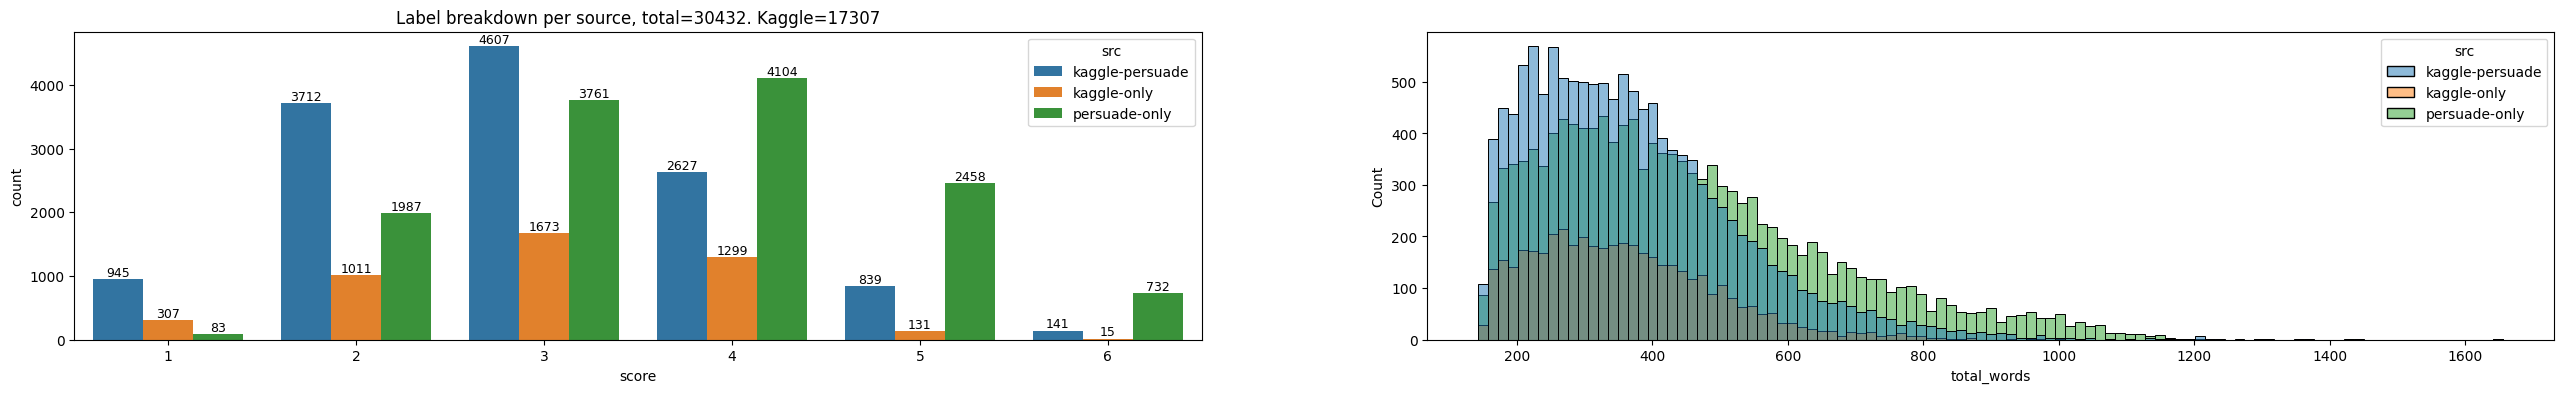

In [7]:
fig, ax = plt.subplots(1,2,figsize=(32,4))
d = sns.countplot(data=train_pd, x="score", hue="src", ax=ax[0])
for i in ax[0].containers:
    ax[0].bar_label(i,fmt='%d', fontsize=9)
d = ax[0].set_title("Label breakdown per source, total=%d. Kaggle=%d"%(len(train_pd), len(train_pd[train_pd["src"].str.contains("kaggle")])))
d = sns.histplot(data=train_pd, x="total_words", hue="src", ax=ax[1])

In [8]:
kaggle_only = train_pd[train_pd["src"].str.contains("kaggle-only")].reset_index()
kaggle_persuade = train_pd[train_pd["src"].str.contains("kaggle-persuade")].reset_index()
persuade_only = train_pd[train_pd["src"].str.contains("persuade-only")].reset_index()
kaggle_only.shape, kaggle_persuade.shape, persuade_only.shape

((4436, 11), (12871, 11), (13125, 11))

# Word cloud

In [9]:
def display_wordcloud(df):
    c = []
    frequency = {}

    for tokens in df["words"].values:
        c.extend(tokens)

        for word in tokens:
            if len(word) > 5:
                if word.lower() not in frequency:
                    frequency[word.lower()]=1
                else:
                    frequency[word.lower()]+=1

    fig, ax = plt.subplots(1,1, figsize=(16, 7))

    # Generate wordclouds
    cloud_freq = WordCloud(
        background_color="white", 
        contour_width=3, 
        contour_color='steelblue',
        width=800, height=400,
        max_words=1000,
        random_state=SEED,
    ).generate_from_frequencies(frequency)

    d = ax.imshow(cloud_freq, interpolation="bilinear")
    d = ax.axis("off")
    d = ax.set_title("Most frequent words")

    plt.tight_layout(pad=4)
    plt.show()

## All data: Kaggle + Persuade 2.0

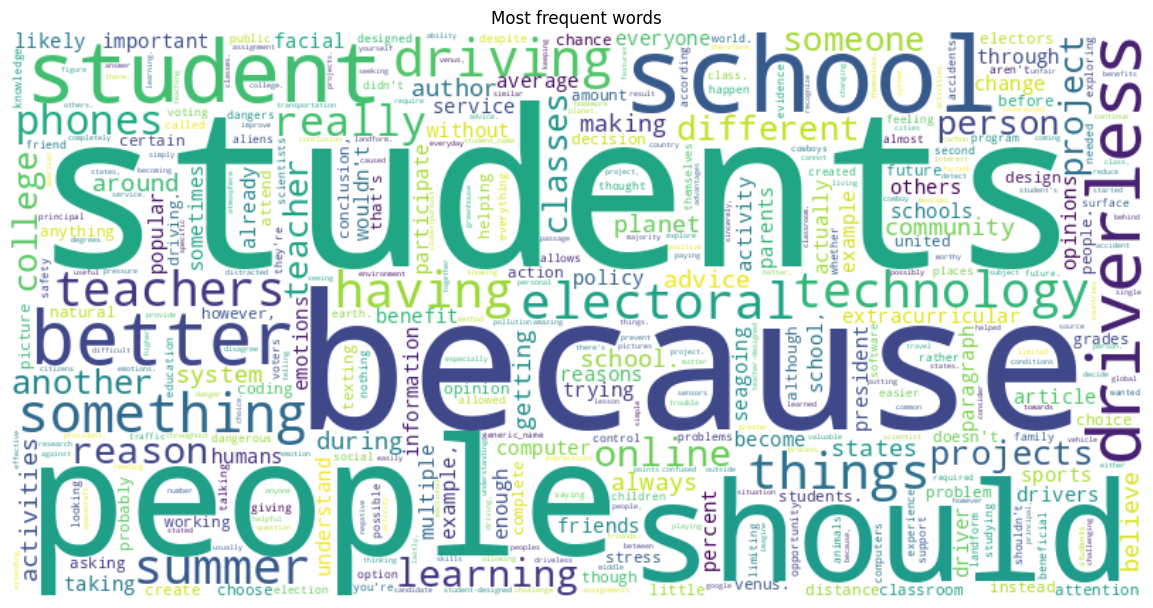

In [10]:
display_wordcloud(train_pd)

## Kaggle only word cloud

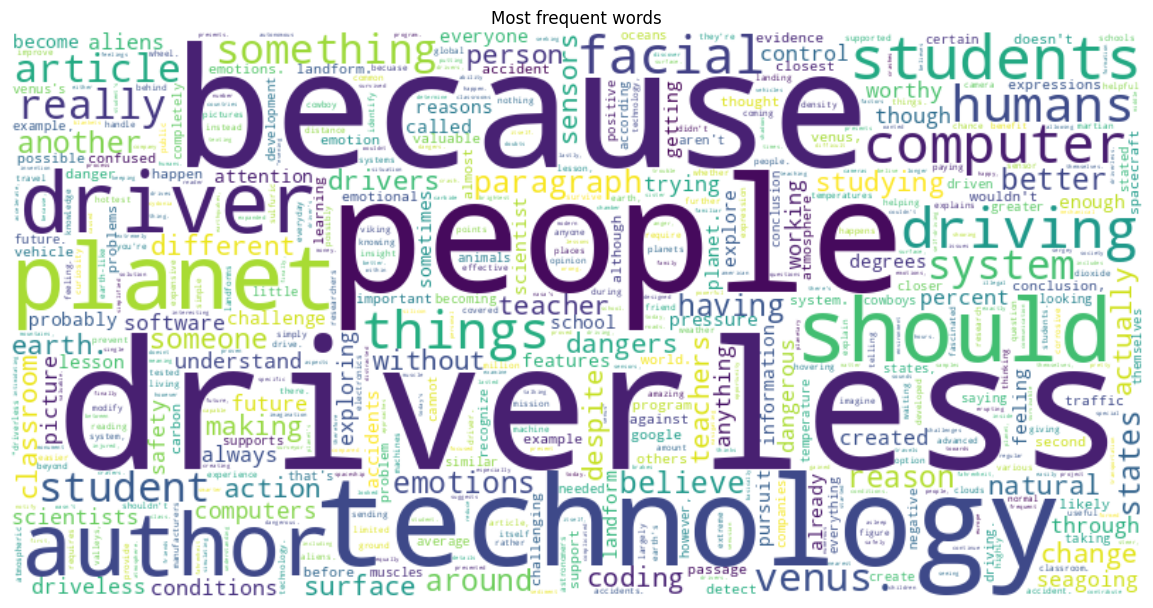

In [11]:
display_wordcloud(kaggle_only)

## Kaggle-persuade word cloud

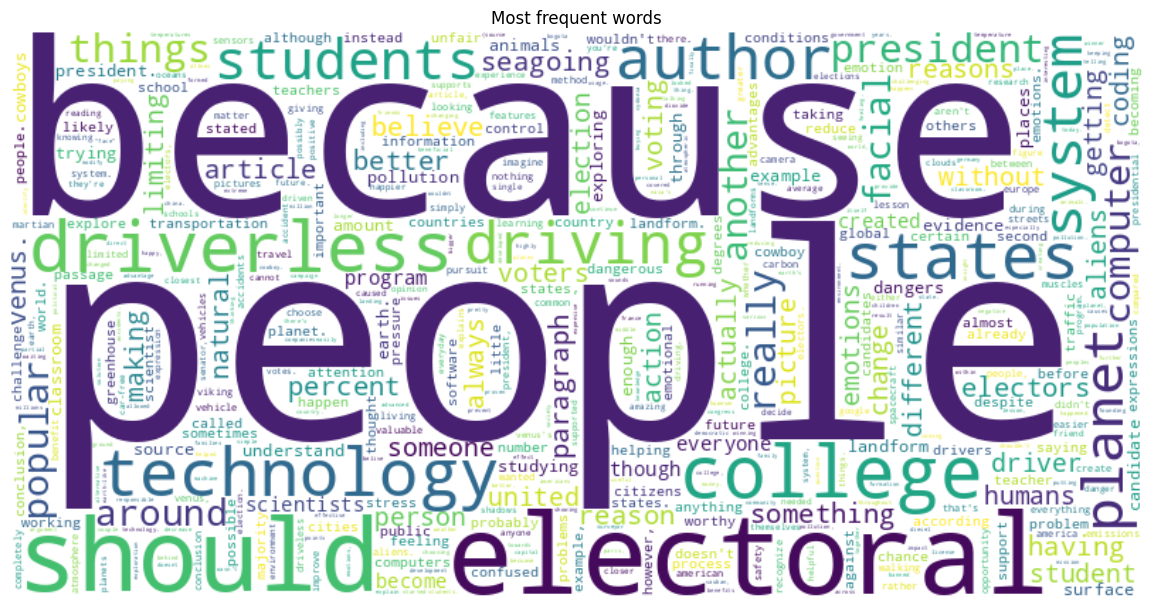

In [12]:
display_wordcloud(kaggle_persuade)

## Persuade only word cloud

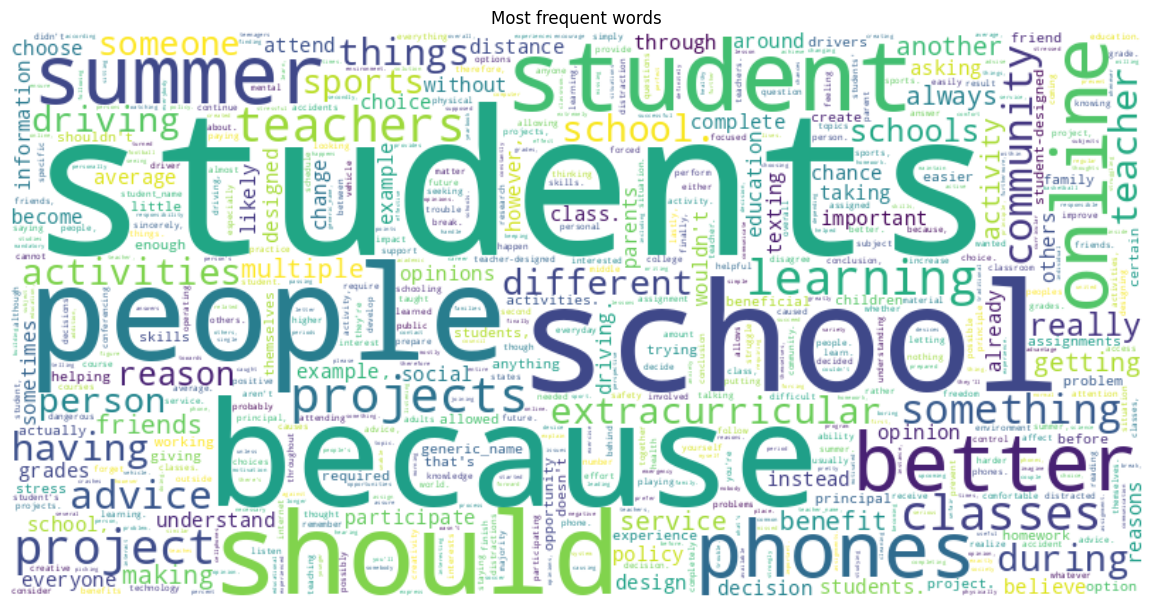

In [13]:
display_wordcloud(persuade_only)

In [14]:
# Cleanup essay
def prepare_document(m, limit=-1):
    txt = ""
    if m is not None:
        txt = m[:limit+1].strip() if limit != -1 else m
    return txt

train_pd["cleaned_text"] = train_pd.apply(lambda x: prepare_document(x["full_text"], limit=-1), axis=1)
train_pd[["essay_id", "cleaned_text", "score"]].head()

essay_id                                       cleaned_text  score
0  000d118  Many people have car where they live. The thin...      3
1  000fe60  I am a scientist at NASA that is discussing th...      3
2  001ab80  People always wish they had the same technolog...      4
3  001bdc0  We all heard about Venus, the planet without a...      4
4  002ba53  Dear, State Senator This is a letter to argue ...      3

# Generate embeddings to prepare topics modeling.

In [15]:
# Data
# train_pd = train_pd.head(1000)
essays = train_pd["cleaned_text"]

# Embedding model
EMB_MODEL = 'hkunlp/instructor-xl' # 'BAAI/bge-large-en'

if 'instructor' in EMB_MODEL:
    embedding_model = INSTRUCTOR(EMB_MODEL)

    # Compute essay embeddings (max_seq_length = 512, embeddings size = 784)
    instruction = "Represent the essay statement: "

    documents = []
    for essay in essays:
        documents.append([instruction ,essay])

    embeddings = embedding_model.encode(documents, show_progress_bar=True, batch_size=32)

else:
    embedding_model = SentenceTransformer(EMB_MODEL)
    embeddings = embedding_model.encode(essays, show_progress_bar=True)

print(embeddings.shape)

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


Batches:   0%|          | 0/951 [00:00<?, ?it/s]

(30432, 768)


# Topics modeling: Reduction, clustering, ngrams extraction

In [16]:
# UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=SEED)

# Clustering
min_cluster_size = 30 # We don't want small clusters
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Extract ngram
top_n_words = 25
vectorizer_model = CountVectorizer(ngram_range=(1,3), min_df=2, stop_words="english", strip_accents="unicode")
representation_model = KeyBERTInspired(top_n_words=top_n_words, nr_repr_docs=5, random_state=SEED)

topic_model = BERTopic(language="english", top_n_words=top_n_words, embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model, representation_model=representation_model, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents=essays, embeddings=embeddings)

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

2024-04-28 12:48:57,747 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-28 12:49:56,235 - BERTopic - Dimensionality - Completed ✓
2024-04-28 12:49:56,237 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-28 12:50:01,898 - BERTopic - Cluster - Completed ✓
2024-04-28 12:50:01,910 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-28 12:51:27,437 - BERTopic - Representation - Completed ✓


In [17]:
chart = topic_model.visualize_barchart(top_n_topics=24, n_words=9, width=512)
chart.show()

In [18]:
train_pd["topic"] = topics
train_pd["topic_keyword"] = train_pd["topic"].apply(lambda x: [t[0] for t in topic_model.get_topic(int(x))])
train_pd.to_parquet("aes2_topics.parquet")
train_pd

essay_id                                          full_text  score  \
0           000d118  Many people have car where they live. The thin...      3   
1           000fe60  I am a scientist at NASA that is discussing th...      3   
2           001ab80  People always wish they had the same technolog...      4   
3           001bdc0  We all heard about Venus, the planet without a...      4   
4           002ba53  Dear, State Senator This is a letter to argue ...      3   
...             ...                                                ...    ...   
30427  18409261F5C2  80% of Americans believe seeking multiple opin...      5   
30428  D46BCB48440A  When people ask for advice,they sometimes talk...      4   
30429  0FB0700DAF44  During a group project, have you ever asked a ...      4   
30430  D72CB1C11673  Making choices in life can be very difficult. ...      4   
30431  DF920E0A7337  Have you ever asked more than one person for h...      4   

                                    uid              src  \
0      c7961eec56c232f1fae190c7b6e1ad1d  kaggle-persuade   
1      6e43449e17c4b9bae4cc781c3e81ea74      kaggle-only   
2      d6d6c3aee23fa6947c811d676c5c0082      kaggle-only   
3      cf3278e04359aa9f0eb387b6909bb67a      kaggle-only   
4      ab9662363df3d32d50ba1ab1507e5ee2  kaggle-persuade   
...                                 ...              ...   
30427  5a7f12d4b072f1e7474172d4ab59f59b    persuade-only   
30428  9c8965488e6b1f4407c955df30362e17    persuade-only   
30429  9ad2ea0ab87ba021c07335f298fd0990    persuade-only   
30430  17b18147b5395970d0be5cecd8942ad7    persuade-only   
30431  12724760f59a66f82e0f7c368ac0b0ec    persuade-only   

                     prompt_name  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   
...                          ...   
30427  Seeking multiple opinions   
30428  Seeking multiple opinions   
30429  Seeking multiple opinions   
30430  Seeking multiple opinions   
30431  Seeking multiple opinions   

                                              assignment  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
30427  When people ask for advice, they sometimes tal...   
30428  When people ask for advice, they sometimes tal...   
30429  When people ask for advice, they sometimes tal...   
30430  When people ask for advice, they sometimes tal...   
30431  When people ask for advice, they sometimes tal...   

                                                   words  total_words  length  \
0      [Many, people, have, car, where, they, live., ...          498    2673   
1      [I, am, a, scientist, at, NASA, that, is, disc...          332    1665   
2      [People, always, wish, they, had, the, same, t...          550    3065   
3      [We, all, heard, about, Venus,, the, planet, w...          451    2697   
4      [Dear,, State, Senator, This, is, a, letter, t...          373    2190   
...                                                  ...          ...     ...   
30427  [80%, of, Americans, believe, seeking, multipl...         1056    6220   
30428  [When, people, ask, for, advice,they, sometime...          363    1918   
30429  [During, a, group, project,, have, you, ever, ...          635    3790   
30430  [Making, choices, in, life, can, be, very, dif...          421    2411   
30431  [Have, you, ever, asked, more, than, one, pers...          711    3782   

                                            cleaned_text  topic  \
0      Many people have car where they live. The thin...      5   
1      I am a scientist at NASA that is discussing th...

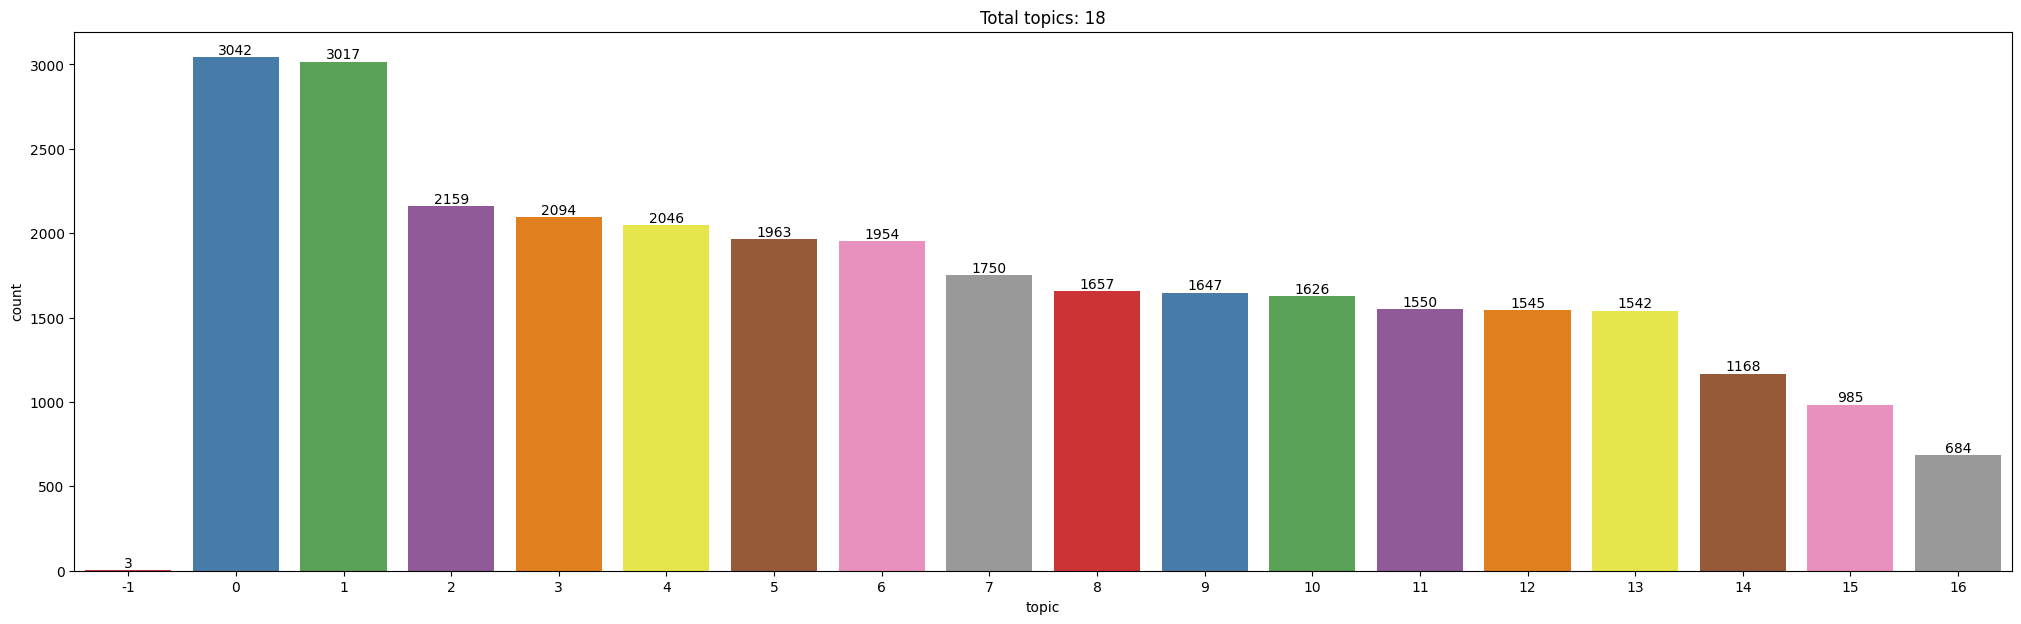

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(25,7))
d = sns.countplot(x="topic", data=train_pd, ax=ax, palette = "Set1")
for i in ax.containers:
    ax.bar_label(i,fmt='%d', fontsize=10)
d = ax.set_title("Total topics: %d" % (len(np.unique(topics))))

In [20]:
umap_2d = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=SEED).fit_transform(embeddings)
train_pd["x"] = umap_2d[:,0]
train_pd["y"] = umap_2d[:,1]

In [21]:
kaggle_only = train_pd[train_pd["src"].str.contains("kaggle-only")].reset_index()
kaggle_persuade = train_pd[train_pd["src"].str.contains("kaggle-persuade")].reset_index()
persuade_only = train_pd[train_pd["src"].str.contains("persuade-only")].reset_index()
kaggle_only.shape, kaggle_persuade.shape, persuade_only.shape

((4436, 16), (12871, 16), (13125, 16))

## Topics related to source

We can notice that some Persuade topics not are in Kaggle (train) topics.

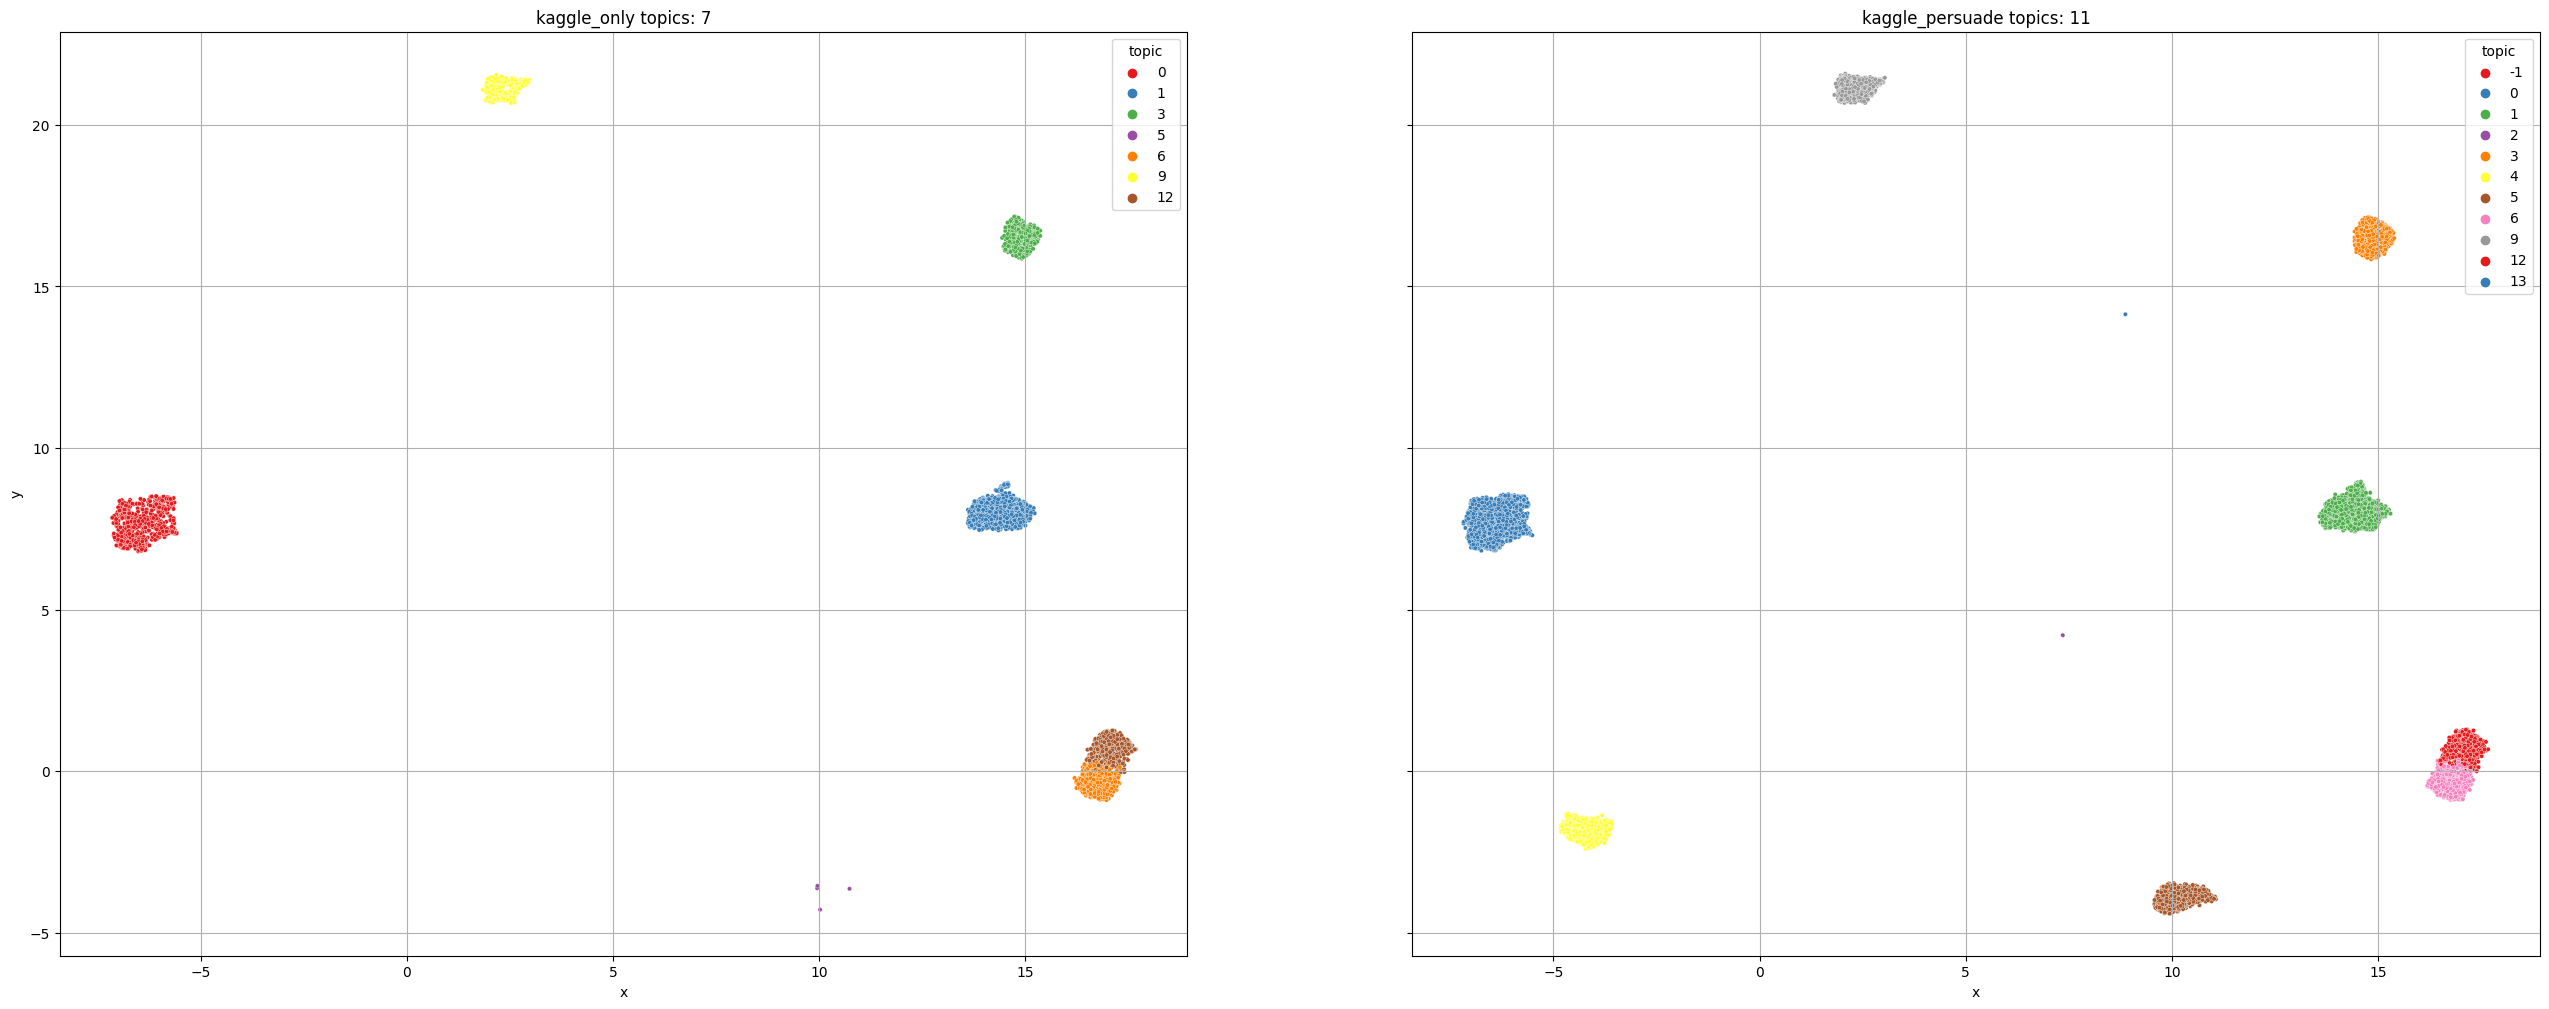

In [22]:
fig, ax = plt.subplots(1,2, figsize=(32,12), sharex=True, sharey=True)
d = sns.scatterplot(data=kaggle_only, x="x", y="y", hue="topic", s=10, ax=ax[0], palette='Set1')
d = ax[0].set_title("kaggle_only topics: %d" % (kaggle_only["topic"].nunique()))
d = ax[0].grid()
d = sns.scatterplot(data=kaggle_persuade, x="x", y="y", hue="topic", s=10, ax=ax[1], palette='Set1')
d = ax[1].set_title("kaggle_persuade topics: %d" % (kaggle_persuade["topic"].nunique()))
d = ax[1].grid()
plt.show()

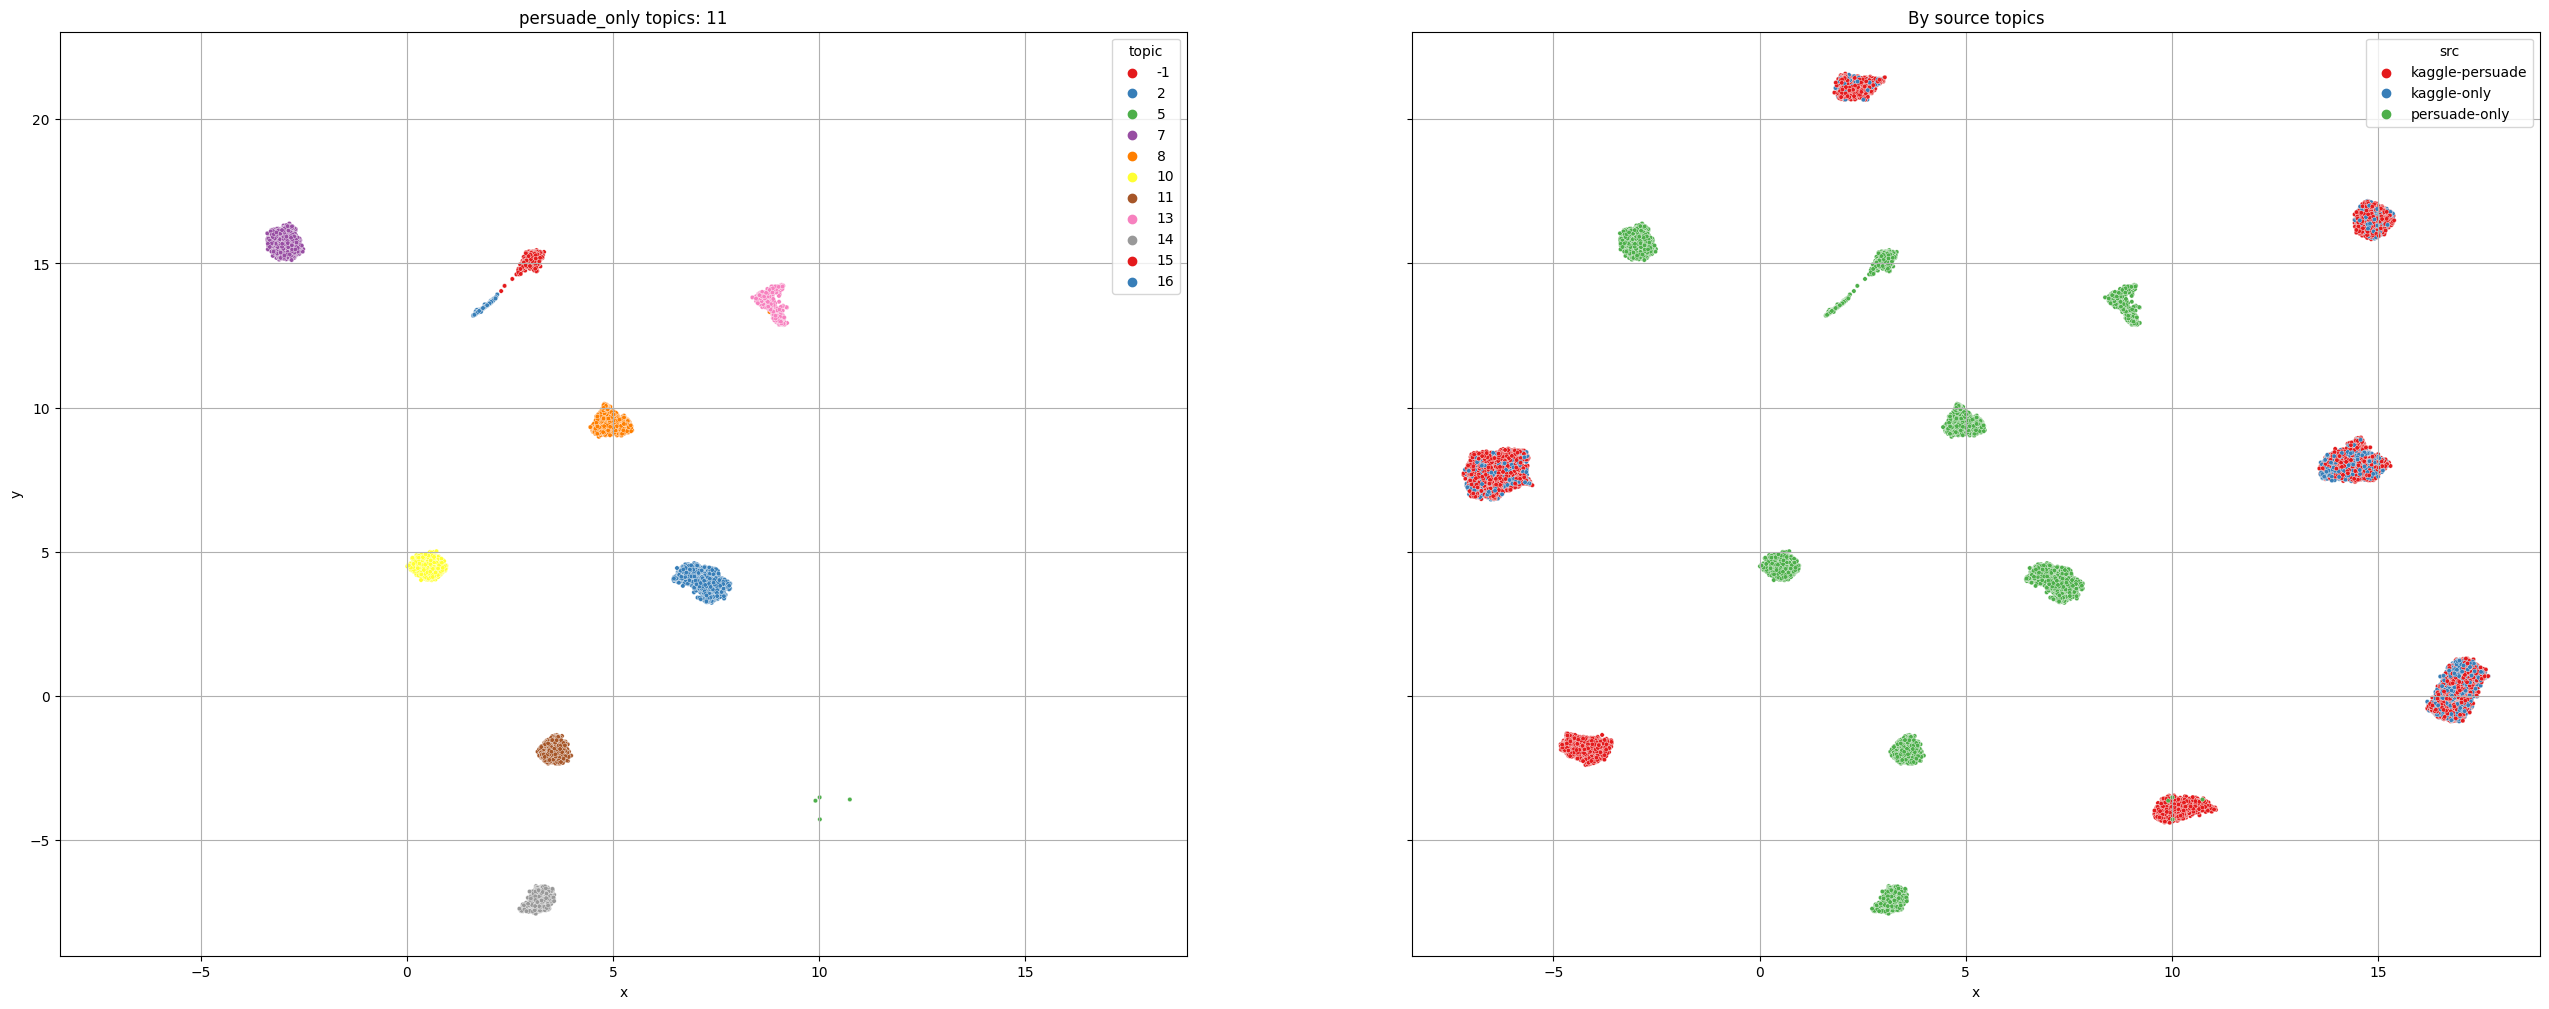

In [23]:
fig, ax = plt.subplots(1,2, figsize=(32,12), sharex=True, sharey=True)
d = sns.scatterplot(data=persuade_only, x="x", y="y", hue="topic", s=10, ax=ax[0], palette='Set1')
d = ax[0].set_title("persuade_only topics: %d" % (persuade_only["topic"].nunique()))
d = ax[0].grid()
d = sns.scatterplot(data=train_pd, x="x", y="y", hue="src", s=10, ax=ax[1], palette='Set1')
d = ax[1].set_title("By source topics")
d = ax[1].grid()
plt.show()

In [24]:
kaggle_topics = pd.concat([kaggle_only, kaggle_persuade], ignore_index=True)["topic"].astype(int).unique()
sorted(kaggle_topics)

[-1, 0, 1, 2, 3, 4, 5, 6, 9, 12, 13]

In [25]:
persuade_only_topics = persuade_only["topic"].astype(int).unique()
sorted(persuade_only_topics)

[-1, 2, 5, 7, 8, 10, 11, 13, 14, 15, 16]

In [26]:
# Common topics
np.intersect1d(kaggle_topics, persuade_only_topics)

array([-1,  2,  5, 13])

In [27]:
train_pd["kaggle_topic"] = np.where(train_pd["topic"].astype(int).isin(kaggle_topics), True, False)

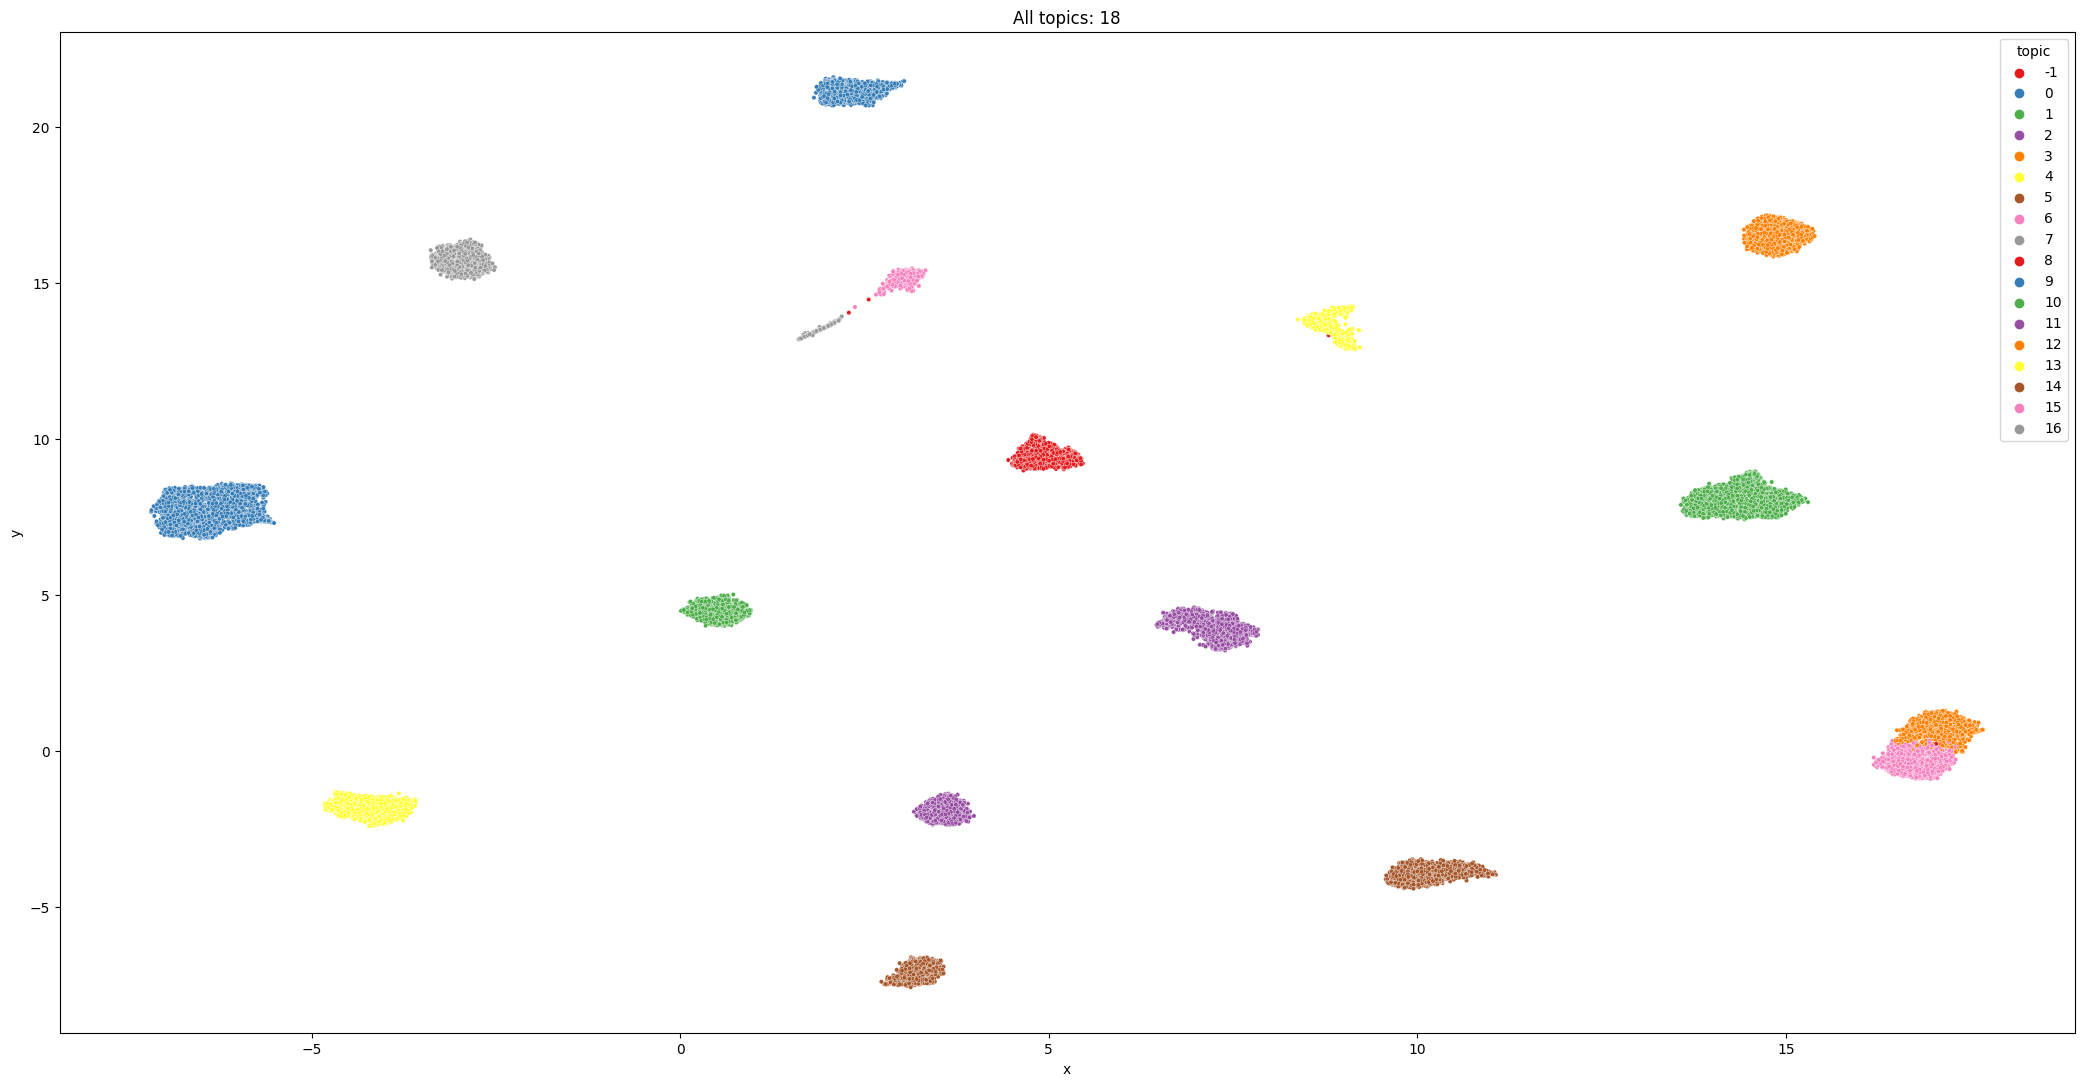

In [28]:
fig, ax = plt.subplots(1,1, figsize=(26,13))
d = sns.scatterplot(data=train_pd, x="x", y="y", hue="topic", s=10, ax=ax, palette='Set1')
d = ax.set_title("All topics: %d" % (train_pd["topic"].nunique()))

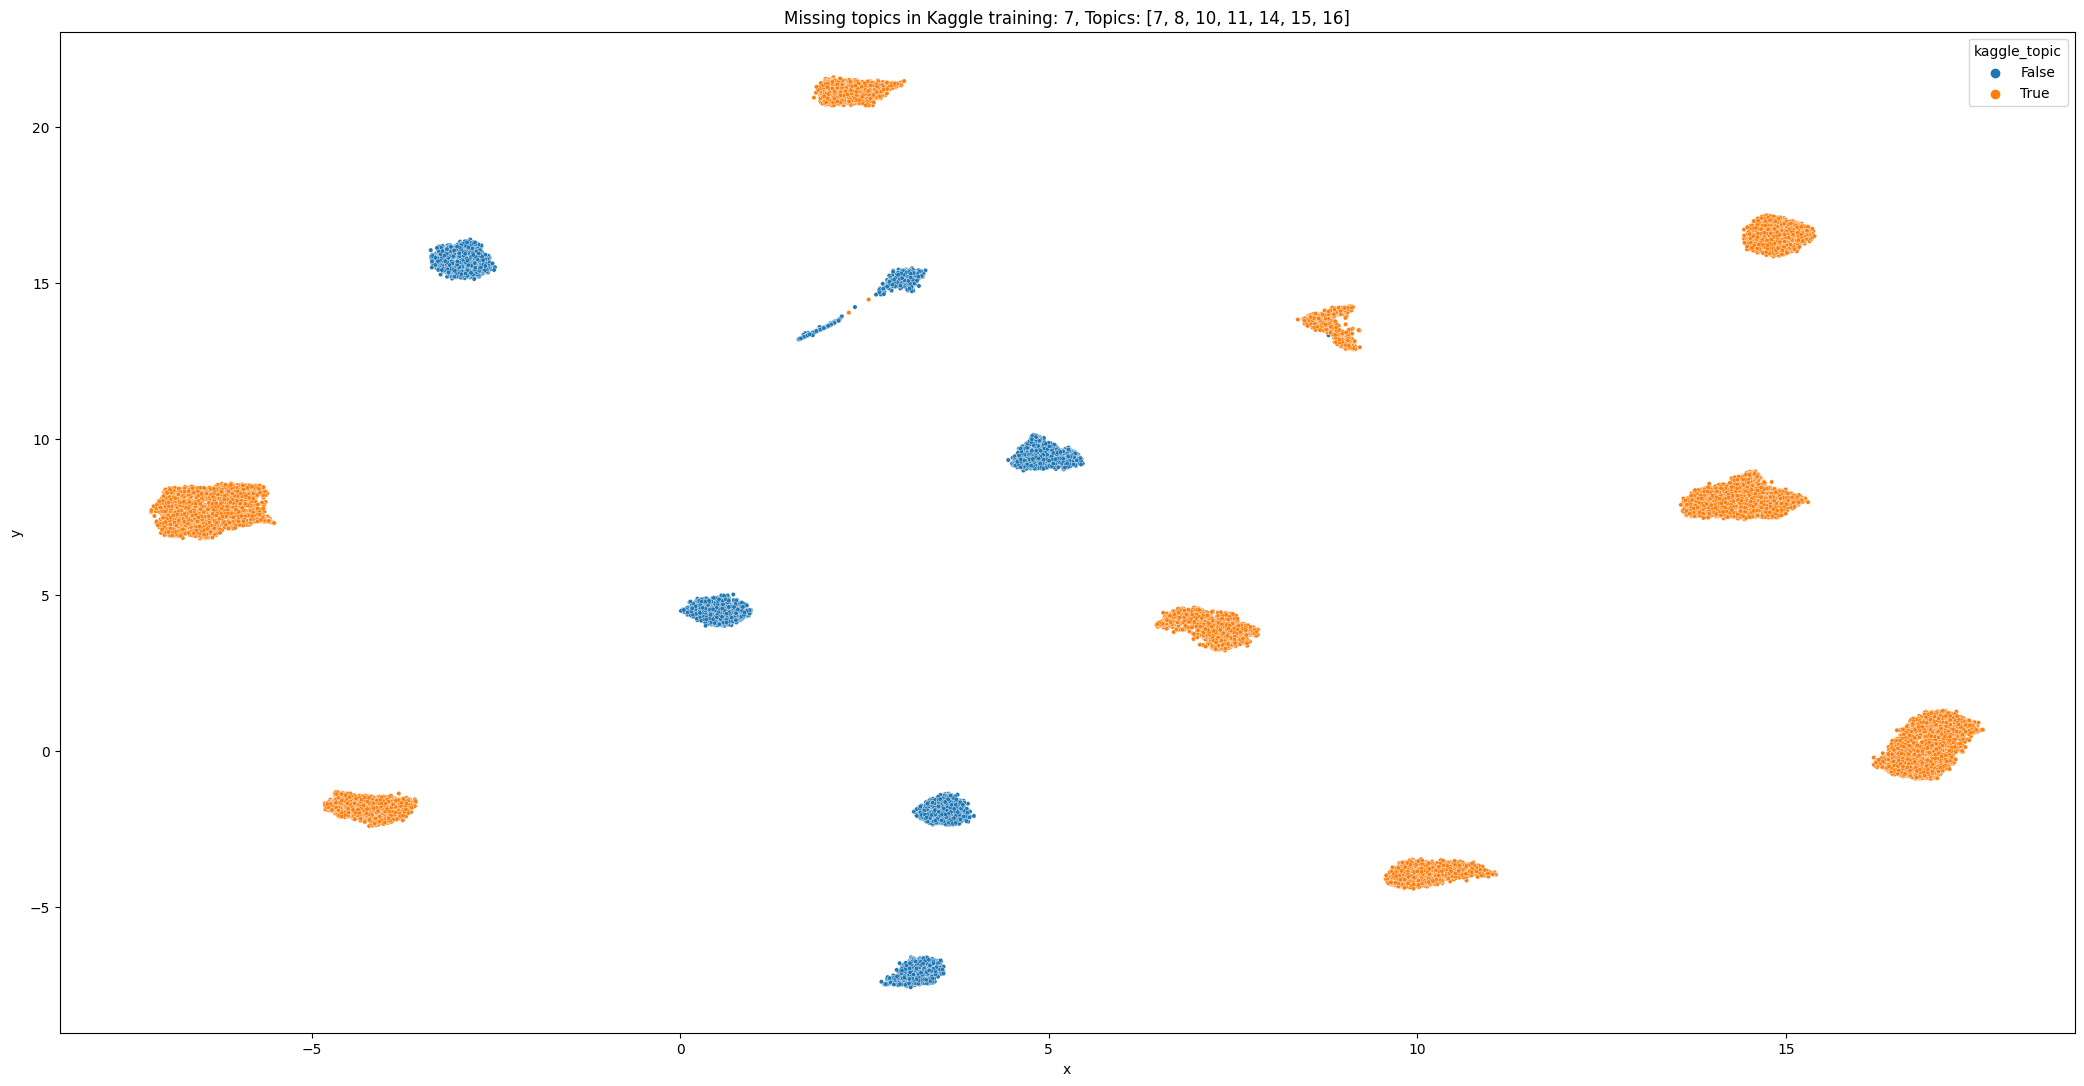

In [29]:
fig, ax = plt.subplots(1,1, figsize=(26,13))
d = sns.scatterplot(data=train_pd, x="x", y="y", hue="kaggle_topic", s=10, ax=ax)
d = ax.set_title("Missing topics in Kaggle training: %d, Topics: %s" % (train_pd[train_pd["kaggle_topic"] == False]["topic"].nunique(), sorted(train_pd[train_pd["kaggle_topic"] == False]["topic"].unique())))

In [30]:
missing_topics = sorted(train_pd[train_pd["kaggle_topic"] == False]["topic"].unique())
missing_topics

[7, 8, 10, 11, 14, 15, 16]

In [31]:
for t in missing_topics:
    kw = train_pd[train_pd["topic"] == t]["topic_keyword"].values[0]
    print("Topic:", t, ":", kw)
    print()

Topic: 7 : ['students design', 'projects students', 'project students', 'projects teacher', 'projects student', 'designed students', 'students summer', 'project student', 'teacher designed', 'students learn', 'projects', 'students', 'students complete', 'students able', 'designing', 'student', 'assignments', 'summer break', 'teachers', 'summer', 'design', 'teacher', 'schools', 'creativity', 'school']

Topic: 8 : ['cell phones school', 'cell phone policy', 'phones school', 'phones class', 'use cell phones', 'phone class', 'school use', 'phone school', 'students use', 'use phones', 'cell phones', 'cell phone', 'allow students', 'phone policy', 'phones free', 'use lunch', 'students bring', 'phones', 'use phone', 'students', 'class time', 'lunch periods', 'lunch free', 'lunch', 'student']

Topic: 10 : ['school sports', 'students average', 'grade average', 'play sports', 'participate sports', 'average students', 'participate sports activities', 'play sport', 'school policy', 'students grade

In [32]:
gp = train_pd.groupby(["src", "topic"])["essay_id"].count().reset_index()
gp.pivot(columns=["topic"], index='src').fillna("")

essay_id                                                  \
topic                -1       0       1       2       3       4       5    
src                                                                        
kaggle-only                876.0  1155.0           511.0             4.0   
kaggle-persuade      1.0  2166.0  1862.0     1.0  1583.0  2046.0  1955.0   
persuade-only        2.0                  2158.0                     4.0   

                                                                        \
topic                6       7       8       9       10      11     12   
src                                                                      
kaggle-only       897.0                   276.0                  717.0   
kaggle-persuade  1057.0                  1371.0                  828.0   
persuade-only            1750.0  1657.0          1626.0  1550.0          

                                               
topic                13      14     15     16  
src                                            
kaggle-only                                    
kaggle-persuade     1.0                        
persuade-only    1541.0  1168.0  985.0  684.0